# Taylor integration of the Kepler problem

Here, we try to reproduce __exactly__ the [Kepler problem integration example](http://nbviewer.jupyter.org/github/JuliaDiff/TaylorSeries.jl/blob/master/examples/1-KeplerProblem.ipynb) made by Luis Benet in [JuliaDiff/TaylorSeries.jl](https://github.com/JuliaDiff/TaylorSeries.jl).

The Kepler problem is the basis of planetary motion; it describes the motion of a secondary body (e.g., a planet, asteroid, comet, etc.), around a primary body (e.g., the Sun). In cartesian coordinates over the orbital plane, the Hamiltonian for the Kepler problem reads:

$$
\begin{align}
H_{\mathrm{Kepler}} &= \frac{1}{2\mu}(p_x^2+p_y^2)-\frac{\mu}{\sqrt{x^2+y^2}}
\end{align}
$$

where $\mu=G(m_1+m_2)$, $G$ is the gravitational constant, $m_1$ is the mass of the primary body and $m_2$ is the mass of the secondary body. If we write $\vec r_1 = (x_1,y_1)$ and $\vec r_2 = (x_2,y_2)$, respectively, for the position of the primary and secondary body, then the vector $\vec r = \vec r_2-\vec r_1$, with coordinates $\vec r = (x, y)=(x_2-x_1,y_2-y_1)$, represents the position of the secondary body relative to the primary body; i.e., $\vec r$ represents the so-called relative coordinates. The primary body is at the origin.

Using Hamilton equations, we can obtain the equations of motion for the Kepler problem:

$$
\begin{align}
\dot x &= u \\
\dot y &= v \\
\dot u &= -\frac{\mu x}{(x^2+y^2)^{3/2}}\\
\dot v &= -\frac{\mu y}{(x^2+y^2)^{3/2}}
\end{align}
$$

Note that the canonical momenta are $p_x$ and $p_y$, while $u$ and $v$ are, respectively, the  $x$ and $y$ components of the velocity; i.e., $p_x = \mu u$ and $p_y = \mu v$. 


First of all, we shall include all relevant packages:

In [1]:
using TaylorIntegration, PyPlot

Some parameters necessary for the integration:

+ $\mu$: the gravitational parameter
+ `q0`: the initial state
+ `order`: the order of the Taylor expansion
+ `t_max`: the final time of the integration
+ `abs_tol`: the absolute tolerance
+ `n_iter`: the number of time-steps

In [2]:
const μ = 1.0
const q0 = [0.19999999999999996, 0.0, 0.0, 3.0] # a initial condition for elliptical motion
const order = 28
const t0 = 0.0
const t_max = 10000*(2π) # we are just taking a wild guess about the period ;)
const abs_tol = 1.0E-20
const steps = 500000

500000

As usual, we write down the equations of motion into a `function`, which here we will name `kepler_problem`. `q` represents the system state, with the first component being the current value of the independent variable. Hence, its evolution is given by $\dot t = 1$. `params` represents the parameters of a given system of differential equations. In the Kepler problem case, the only parameter is $\mu$, the mass parameter.

In [3]:
function kepler_problem(t, q)
    r_p3d2 = (q[1]^2+q[2]^2)^(3/2)
    
    return [q[3], q[4], -μ*q[1]/r_p3d2, -μ*q[2]/r_p3d2]
end

kepler_problem (generic function with 1 method)

The Taylor integration:

In [4]:
?taylorinteg

search: taylorinteg TaylorIntegration



```
taylorinteg(f, x0, t0, tmax, order, abs_tol; keyword... )
```

This is a general-purpose Taylor integrator for the explicit ODE $\dot{x}=f(t,x)$ with initial condition specified by `x0` at time `t0`. It returns a vector with the values of time (independent variable), and a vector (of type `typeof(x0)`) with the computed values of the dependent variables. The integration stops when time is larger than `tmax`, or the number of saved steps is larger than `maxsteps`.

The integrator uses polynomial expansions on the independent variable of order `order` and the parameter `abs_tol` serves to define the time step using the last two Taylor coefficients of the expansions.

The current keyword argument is `maxsteps=500`.


In [5]:
t, q = taylorinteg(kepler_problem, q0, t0, t_max, order, abs_tol, maxsteps=2); #warm-up lap
@time t, q = taylorinteg(kepler_problem, q0, t0, t_max, order, abs_tol, maxsteps=steps);

 48.484457 seconds (621.08 M allocations: 39.178 GB, 8.69% gc time)


The final state:

In [6]:
t[end], q[end,:]

(62831.853071795864,
1x4 Array{Float64,2}:
 0.196132  0.0527212  -0.432649  2.94287)

Let's extract the values of $x$, $y$, $u$ and $v$ for each time-step:

In [7]:
x = q[:,1] #x position
y = q[:,2] #y position
u = q[:,3] #x velocity
v = q[:,4]; #y velocity

## Orbital motion

The initial conditions we selected correspond to a elliptical orbit with a relatively high eccentricity: $e=0.8$ for the initial condition `q0=[0.19999999999999996, 0.0, 0.0, 3.0]`. How does the motion of the planet/asteroid/comet looks like? Well, let's plot its orbits over the $x-y$ plane (the orbit is shown in blue; the position of the primary body is shown as a yellow dot):

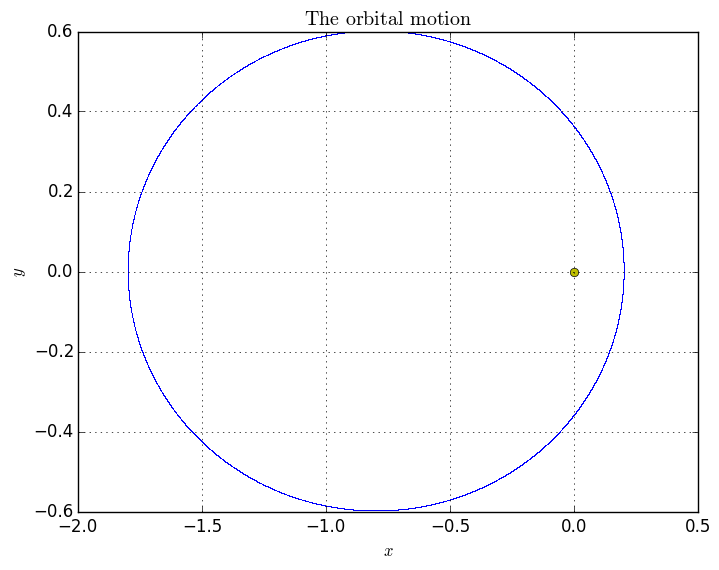

In [8]:
title(L"\mathrm{The\,orbital\,motion}")
ylabel(L"y")
xlabel(L"x")
grid(true)
plot(0,0,"yo")
plot(x,y,",");

## Energy conservation

Below, we write the energy function of the Kepler problem; i.e., the Hamiltonian $H_{\mathrm{Kepler}}$ in terms of $x$, $y$, $u$ and $v$:

In [9]:
H(x_, y_, u_, v_) = 0.5.*(u_.*u_+v_.*v_)-μ./sqrt(x_.*x_+y_.*y_)

H (generic function with 1 method)

Now, using the function `H` defined above, we calculate the energy during each time-step:

In [10]:
E = H(x, y, u, v);

$E_0=H_{\mathrm{Kepler}}(x_0,y_0,u_0,v_0)$, the initial value of the energy, is:

In [11]:
E0=E[1]

-0.5000000000000009

We define $\delta E$ as the relative error in the energy; i.e.:

$$
\begin{align}
\delta E(t) &= \frac{E(t)-E_0}{E_0}
\end{align}
$$

In [12]:
δE = (E-E0)/(E0)

436153-element Array{Float64,1}:
 -0.0        
  1.77636e-15
  1.77636e-15
  8.88178e-16
  8.88178e-16
  2.66454e-15
  3.55271e-15
  2.66454e-15
  3.55271e-15
  2.66454e-15
  3.9968e-15 
  2.66454e-15
  3.10862e-15
  ⋮          
 -7.12763e-14
 -7.19425e-14
 -7.14984e-14
 -7.10543e-14
 -7.19425e-14
 -7.10543e-14
 -7.10543e-14
 -6.92779e-14
 -7.01661e-14
 -6.92779e-14
 -6.92779e-14
 -7.28306e-14

The analytical solution preserves the energy; i.e., $\delta E(t)=0$ for the analytical solution. Thus, we expect our solution to be close to zero. So, even if the $\delta E$ is not perfectly zero during the whole integration, it is comparable to Julia's `Float64` machine-epsilon.

Below, we plot $\delta E$ in units of Julia's `Float64` machine-epsilon as a function of time, $t$. In Julia, the machine-epsilon for the `Float64` type has a value

In [13]:
eps(Float64)

2.220446049250313e-16

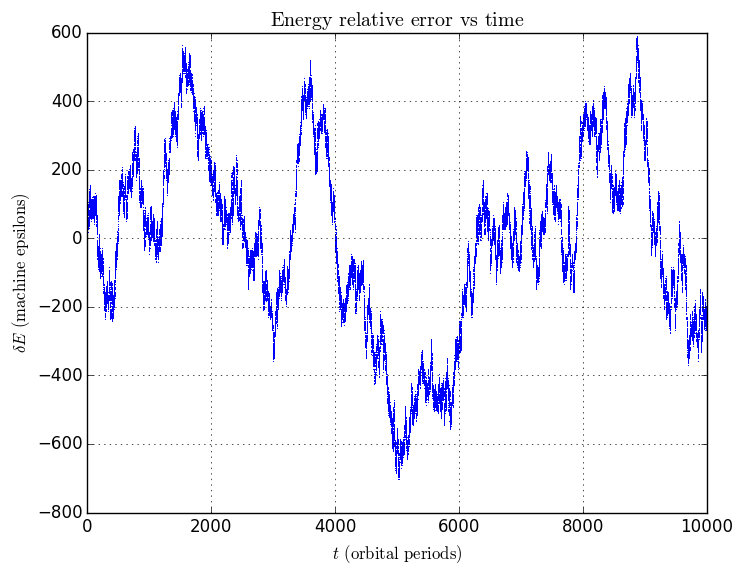

In [14]:
title(L"\mathrm{Energy\,relative\,error\,vs\,time}")
xlabel(L"t\mathrm{\,(orbital\,periods)}")
ylabel(L"\delta E \mathrm{\,(machine\,epsilons)}")
grid(true)
plot(t/(2π), δE/eps(Float64), ",");

Now, how does the energy error distribute around zero?

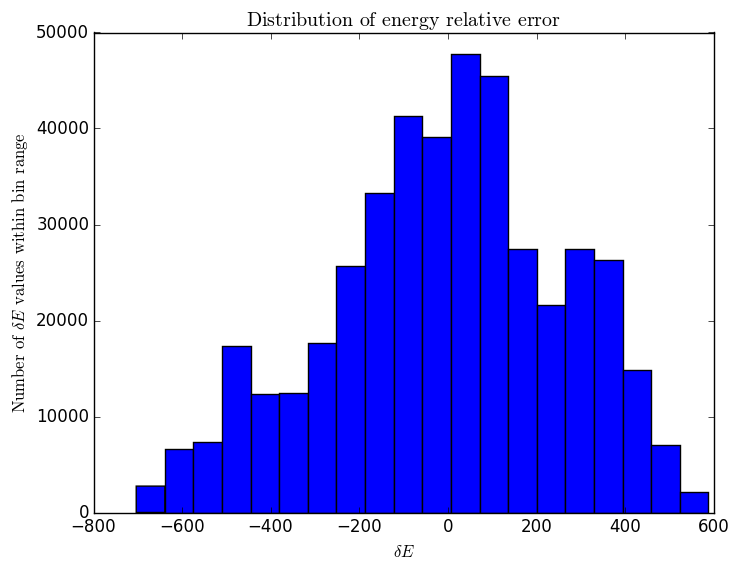

In [15]:
title(L"\mathrm{Distribution\,of\,energy\,relative\,error}")
xlabel(L"\delta E")
ylabel(L"\mathrm{Number\,of\,}\delta E\mathrm{\,values\,within\,bin\,range}")
hE = plt[:hist](δE/eps(Float64), 20);

The energy error behaves roughly as a random walk, which means that the numerical error in the energy is dominated by rounding errors.

## Angular momentum conservation

Analogously to the energy, we now focus on the angular momentum, which is preserved by the analytical solution too. The value of the angular momentum is given by
$$
\begin{align}
L &= xv-yu
\end{align}
$$
We write the angular momentum function as:

In [16]:
ang_mom(x_, y_, u_, v_) = x_.*v_-y.*u_

ang_mom (generic function with 1 method)

So the angular momentum during each time-step is:

In [17]:
L = ang_mom(x, y, u, v);

$L_0=x_0v_0-y_0u_0$, the initial value of the angular momentum, is:

In [18]:
L0 = L[1]

0.5999999999999999

We define $\delta L$ as the relative error in the angular momentum; i.e.:

$$
\begin{align}
\delta L(t) &= \frac{L(t)-L_0}{L_0}
\end{align}
$$

In [19]:
δL = (L-L0)/L0;

Just as we did for the energy, we now plot $\delta L$ in units of `eps(Float64)` vs $t$:

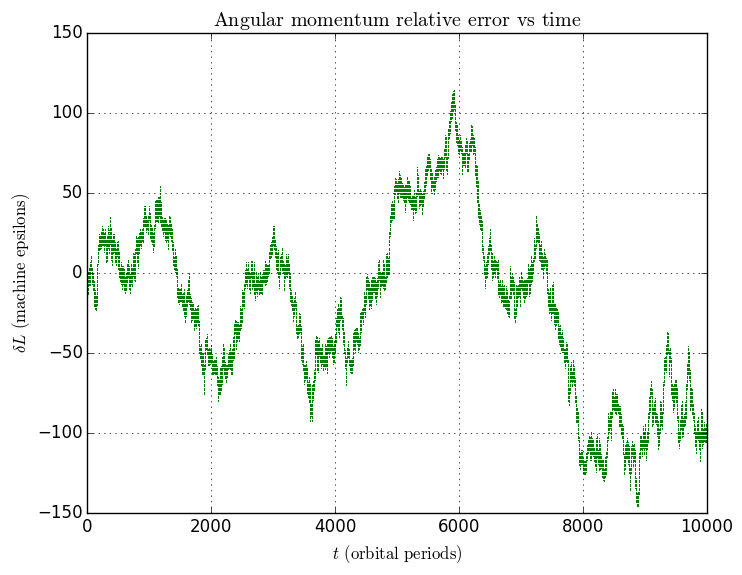

In [20]:
title(L"\mathrm{Angular\,momentum\,relative\,error\,vs\,time}")
xlabel(L"t\mathrm{\,(orbital\,periods)}")
ylabel(L"\delta L \mathrm{\,(machine\,epsilons)}")
grid(true)
plot(t/(2π), δL/eps(Float64), "g,");

Again, we see that the angular momentum relative error is comparable to `eps(Float64)`; the maximum variation is ~$150$ machine epsilons. How does the distribution of this error look like?

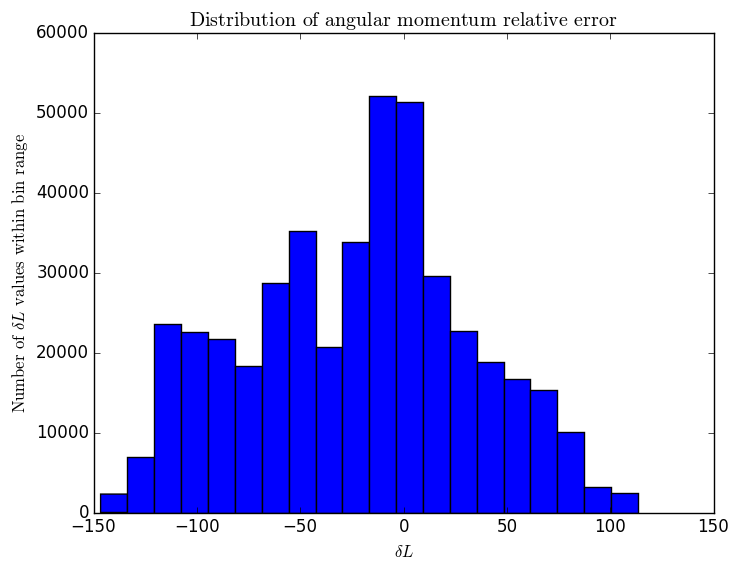

In [21]:
title(L"\mathrm{Distribution\,of\,angular\,momentum\,relative\,error}")
xlabel(L"\delta L")
ylabel(L"\mathrm{Number\,of\,}\delta L\mathrm{\,values\,within\,bin\,range}")
hL = plt[:hist]( δL/eps(Float64), 20 );

The distribution of $\delta L$ shows a peak near zero and roughly symmetrical around this value. This means that the error in the angular momentum is dominated also by rounding errors of floating-point arithmetic.

Lastly, we reproduce __exactly__ the last plot shown in the original version of this example, authored by Luis Benet and included in `JuliaDiff/TaylorSeries.jl`'s [Kepler problem integration example](http://nbviewer.jupyter.org/github/JuliaDiff/TaylorSeries.jl/blob/master/examples/1-KeplerProblem.ipynb) jupyter notebook.

A $\delta E$, $\delta L$ plot vs $t$:

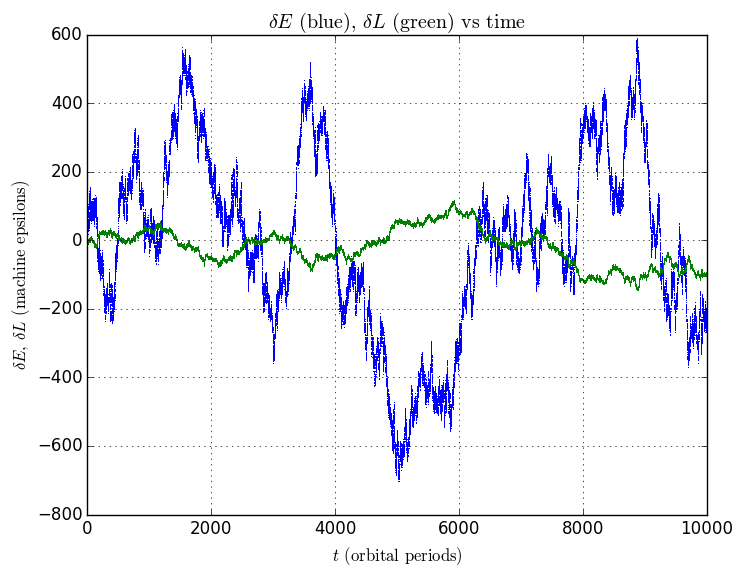

In [22]:
title(L"\delta E\mathrm{\,(blue),\,}\delta L\mathrm{\,(green)\,vs\,time}")
ylabel(L"\delta E\mathrm{,\,}\delta L\,\mathrm{(machine\,epsilons)}")
xlabel(L"t\,\mathrm{(orbital\,periods)}")
grid(true)
plot(t/(2π), δE/eps(Float64), "b,", t/(2π), δL/eps(Float64), "g,");